In [18]:
import pandas as pd
import functions.mgfReader as mgfReader
import matplotlib.pyplot as plt

# Functions

## Name processing 

For combined dataset
- Process well names
- Find well belonging

In [2]:

def process_col_names(df, cut_off):
    msms=df.copy()
    col=msms.columns
    new=[]
    for name in col:
        if "5_P" in name:
            new_name=name[5:9].replace("-","0").strip("_")
            msms[name] = msms[name].apply(lambda x: x if x > cut_off else 0 )
            if len(new_name)==4:
                if new_name[-1]=="0": 
                    new_name=new_name.replace("0","")
                    new_name=new_name+"0"
                    new.append(new_name)
                else:
                    new.append(new_name.replace("0",""))
            else:
                new.append(new_name)
        else:
            new.append(name)
    
    msms.columns=new
    return msms


In [3]:
def add_id(df):
    c=0
    msms=df.copy()
    msms["Well"]=None
    for i, name in enumerate (msms.index):
        value=list(msms.iloc[i,12:-1])
        if value.count(0) ==len(msms.iloc[i,12:-1])-1:
            df=msms.iloc[i,12:-1]
            msms.loc[name,"Well"]=(str(df.loc[~(df==0)].index.values).strip("[").strip("]")[1:-1])
            c=c+1

        else:
            msms.loc[i,"Well"]="Nan"
    print("Number of mz found in just one sample: ",c )
    msms_filtered=msms[msms["Well"]!="Nan"]
    return msms_filtered


## Find closest match

In [4]:
def find_closest(numbers, target):
    return min(numbers, key=lambda x: abs(x- target))

def find_match(numbers,target, ppm):
    closest=find_closest(numbers, target)
  
    if abs(closest-target)<target*ppm*10**-6:
        return closest

def count_matches(data,msms_list,target_list,ppm):
    data=data.copy()
    match=[]
    not_found=[]
    target_mass=target_list["Exact Mass"]
    target_smiles=target_list["SMILES"]
    target_INCHIKEY=target_list["INCHIKEY"]
    target_name=target_list["Sample Name"]
    for i in target_list.index:
        m=find_match(msms_list,target_mass[i],ppm)
        if m:
            match.append(target_mass[i])
            j=data.index[data['PEPMASS']==m].tolist()
            
            data.loc[j,"Target"]=float(target_mass[i])
            data.loc[j,"SMILES"]=target_smiles[i]
            data.loc[j,"INCHIKEY"]=target_INCHIKEY[i]
            data.loc[j,"Name"]=target_name[i]
            
           
        else:
            not_found.append(target_mass[i])
    #print(data.dropna(subset="Target").sort_values("Target"))
    print("Found", len(match), "/", len(target_mass), "matches at", ppm,"ppm")
    return match,not_found,data

## Match one well

In [5]:
def match_one_well(df,well,ppm):

    target_data=well
    
    
    print("----- Targeting", target_data)
    
    #Sort out target
    target_list=values_df[values_df["Position"]==target_data.split()[0]]
    
    internal_s=pd.read_csv("../Tims_tof_första_plattan/internal_standards.csv", sep=";")
    #internal_s=internal_s["Exact Mass"]
    
    #Get list of found values in MetaboScape
    data_in=df[df["Well"]==target_data]
    msms_list=data_in["PEPMASS"]
    
    
    match,not_found,data_out=count_matches(data_in,msms_list,target_list,ppm)
    print("Internal Standard")
    i_match,i_not_found=count_matches(data_in,msms_list,internal_s,ppm)[0:-1]
    return match,not_found,i_match,i_not_found,data_out

## Plot

In [6]:


def plot_findings(well, ppm):
    fig,ax=plt.subplots(1,3, figsize=(20,7),sharey=True, sharex=True)
    
    match,not_found,i_match,i_not_found=match_one_well(msms,well,ppm)[0:4]
    x_multi = [n for n in [i_match, i_not_found, match, not_found]]
    
    ax[0].hist(x_multi, 20, histtype='bar',label=["Internal standard found","Internal standard missing","Target found","Target missing"])
    ax[0].legend()
    ax[0].set_title("Found "+ str(len(match)) +" matches for combined well analysis")
    ax[0].set_xlabel("Target M")
    
    match,not_found,i_match,i_not_found=match_one_well(msms_old,well,ppm)[0:4]
    x_multi = [n for n in [i_match, i_not_found, match, not_found]]
    
    ax[1].hist(x_multi, 20, histtype='bar',label=["Internal standard found","Internal standard missing","Target found","Target missing"])
    ax[1].legend()
    ax[1].set_title("Found "+ str(len(match)) +" matches for combined well analysis, first run")
    ax[1].set_xlabel("Target M")
    
    
    path="../Tims_tof_första_plattan/Exported data/"+well+"/" + well + ".msmsonly.csv"
    msms_one=pd.read_csv(path)
    print("----- Targeting", well)
    target_list=values_df[values_df["Position"]==well.split()[0]]
    internal_s=pd.read_csv("../Tims_tof_första_plattan/internal_standards.csv", sep=";")
    
    match,not_found,data_out=count_matches(msms_one,msms_one["PEPMASS"],target_list,ppm)
    print("Internal Standard")
    
    i_match,i_not_found=count_matches(msms_one,msms_one["PEPMASS"],internal_s,ppm)[0:-1]
    x_multi = [n for n in [i_match, i_not_found, match, not_found]]
    
    ax[2].hist(x_multi, 20, histtype='bar',label=["Internal standard found","Internal standard missing","Target found","Target missing"])
    ax[2].legend()
    ax[2].set_title("Found "+ str(len(match)) +" matches for single well analysis")
    ax[2].set_xlabel("Target M")
    fig.suptitle(well + " at tolerance "+str( ppm)+"ppm", fontsize=20)

In [7]:
def plot_match_and_error(msms, well,ppm):
    fig,ax=plt.subplots(1,2,figsize=(12, 5))
    
    match,not_found,i_match,i_not_found,data_out=match_one_well(msms,well,ppm)
    x_multi = [n for n in [i_match, i_not_found, match, not_found]]
    
    ax[0].hist(x_multi, 20, histtype='bar',label=["Internal standard found","Internal standard missing","Target found","Target missing"])
    ax[0].legend()
    ax[0].set_title( str(len(match)) +" matches")
    ax[0].set_xlabel("Target M")
    
    data=data_out.dropna(subset="Target")
    ax[1].scatter(data["Target"],data["PEPMASS"]-data["Target"])
    ax[1].set_ylabel("Diff in Da")
    ax[1].set_xlabel("Target M")
    ax[1].set_title("Diff at "+str(ppm)+"ppm")
    ax[1].axhline(y=0, color='r', linestyle='-')

# Find matches

In [8]:
values_df=pd.read_csv("../Tims_tof_första_plattan/first_plate_targets.csv", sep=";")
#msms_recu=pd.read_csv("first_plate/Exported_data/A01-B23_recursive_fitting/A01-B23.msmsonly.csv")
msms_old=pd.read_csv("../Tims_tof_första_plattan/Exported data/A01_B23_no_recursive_fitting/A01-B23_no_rec.msmsonly.csv")
msms=pd.read_csv("../New_run/A01-C24_50/A01-C24.msmsonly.csv")

msms=process_col_names(msms,2000)
msms_old=process_col_names(msms_old, 2000)


#### Special as 3 A01 was present"
cols=list(range(1,74))
cols.remove(12)
cols.remove(13)
msms=msms.iloc[:,cols]
############



msms=add_id(msms)
msms_old=add_id(msms_old)


C:\Users\klds816\AppData\Local\Temp\ipykernel_3872\2196316005.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  values_df=pd.read_csv("../Tims_tof_första_plattan/first_plate_targets.csv", sep=";")


Number of mz found in just one sample:  10119
Number of mz found in just one sample:  15309


## Plot matches for specific well

----- Targeting A14
Found 38 / 94 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
----- Targeting A14
Found 22 / 94 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
----- Targeting A14
Found 39 / 94 matches at 10 ppm
Internal Standard
Found 1 / 4 matches at 10 ppm


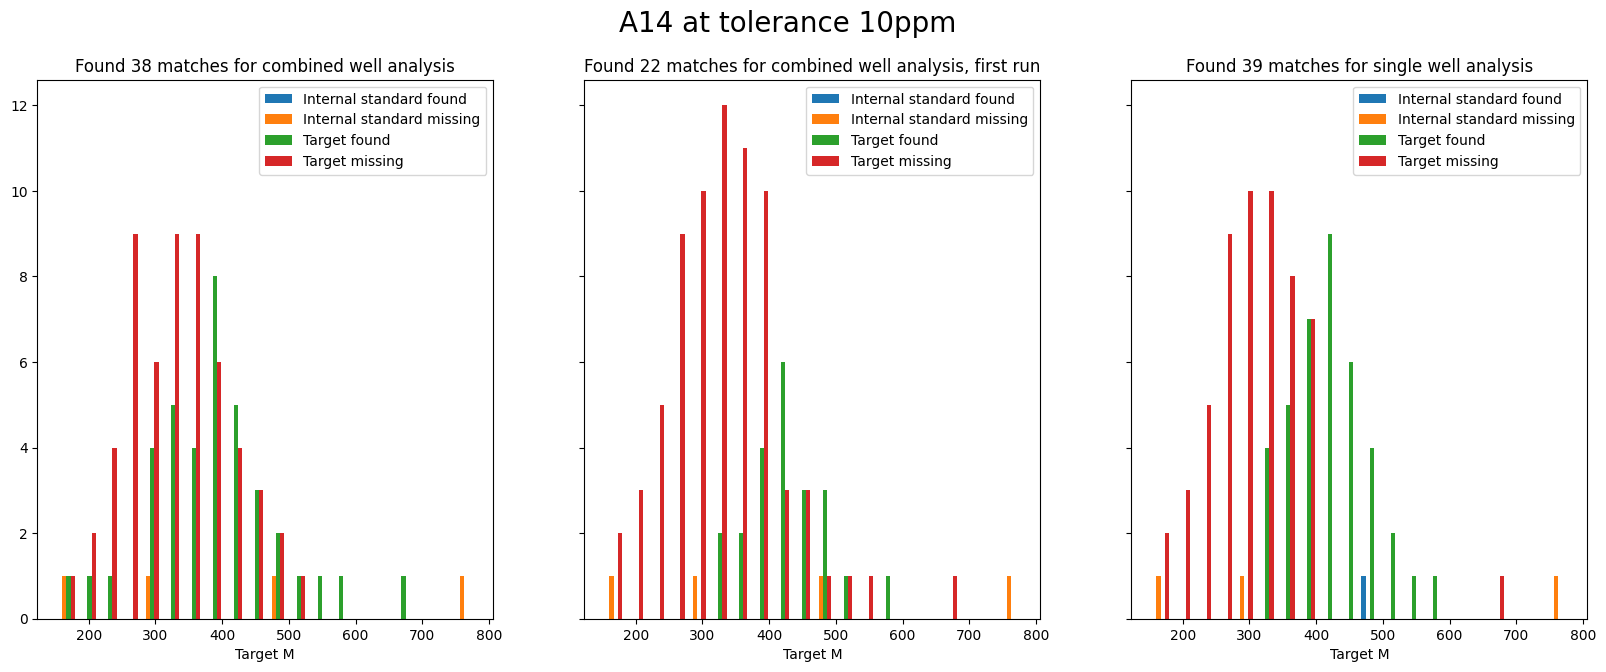

In [10]:
plot_findings(well="A14",ppm=10)

## Run through all wells 

In [49]:

tot=0
for well in msms["Well"].unique():
    match,not_found,i_match,i_not_found=match_one_well(msms,well,10)[0:4]
    tot=tot+len(match)
print("A total of ", tot, "matches")    

----- Targeting C06
Found 9 / 96 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
----- Targeting B11
Found 45 / 94 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
----- Targeting B21
Found 39 / 95 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
----- Targeting C12
Found 43 / 95 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
----- Targeting A07
Found 38 / 97 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
----- Targeting A24
Found 43 / 91 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
----- Targeting B12
Found 44 / 97 matches at 10 ppm
Internal Standard
Found 1 / 4 matches at 10 ppm
----- Targeting B03
Found 11 / 89 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
----- Targeting A09
Found 14 / 90 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
----- Targeting B10
Found 8 / 92 matches at 10 ppm
Internal Standard
Found 0 / 4 matches at 10 ppm
--

## Combine single datafiles

In [14]:
data_combined=pd.DataFrame(columns=msms.columns)
ppm=20
well_list=['A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14']
for well in well_list:#['A06', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10']:#msms["Well"].unique():
    data_out=match_one_well(msms,well,ppm)[4]
    data_combined=pd.concat([data_combined,data_out])


data_combined_old=pd.DataFrame(columns=msms.columns)

for well in well_list :#['A06', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10']:#msms_old["Well"].unique():
    data_out=match_one_well(msms_old,well,ppm)[4]
    data_combined_old=pd.concat([data_combined_old,data_out])


data_combined_single=pd.DataFrame(columns=msms.columns)
for well in well_list:

    path="../Tims_tof_första_plattan/Exported data/"+well+"/" + well + ".msmsonly.csv"
    msms_one=pd.read_csv(path)
    print("----- Targeting", well)
    target_list=values_df[values_df["Position"]==well.split()[0]]

    match,not_found,data_out=count_matches(msms_one,msms_one["PEPMASS"],target_list,ppm)
    data_combined_single=pd.concat([data_combined_single,data_out])

----- Targeting A02
Found 39 / 97 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A03
Found 36 / 92 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A04


C:\Users\klds816\AppData\Local\Temp\ipykernel_3872\3336892417.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_combined=pd.concat([data_combined,data_out])


Found 41 / 93 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A05
Found 45 / 96 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A06
Found 33 / 94 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A07
Found 42 / 97 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A08
Found 48 / 98 matches at 20 ppm
Internal Standard
Found 1 / 4 matches at 20 ppm
----- Targeting A09
Found 29 / 90 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A10
Found 44 / 96 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A11
Found 48 / 98 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A12
Found 38 / 92 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A13
Found 47 / 94 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A14


C:\Users\klds816\AppData\Local\Temp\ipykernel_3872\3336892417.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_combined_old=pd.concat([data_combined_old,data_out])


----- Targeting A07
Found 24 / 97 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A08
Found 21 / 98 matches at 20 ppm
Internal Standard
Found 2 / 4 matches at 20 ppm
----- Targeting A09
Found 30 / 90 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A10
Found 16 / 96 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A11
Found 32 / 98 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A12
Found 14 / 92 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A13
Found 45 / 94 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A14
Found 29 / 94 matches at 20 ppm
Internal Standard
Found 0 / 4 matches at 20 ppm
----- Targeting A02
Found 16 / 97 matches at 20 ppm
----- Targeting A03


C:\Users\klds816\AppData\Local\Temp\ipykernel_3872\3336892417.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_combined_single=pd.concat([data_combined_single,data_out])


Found 4 / 92 matches at 20 ppm
----- Targeting A04
Found 5 / 93 matches at 20 ppm
----- Targeting A05
Found 3 / 96 matches at 20 ppm
----- Targeting A06
Found 32 / 94 matches at 20 ppm
----- Targeting A07
Found 50 / 97 matches at 20 ppm
----- Targeting A08
Found 29 / 98 matches at 20 ppm
----- Targeting A09
Found 54 / 90 matches at 20 ppm
----- Targeting A10
Found 27 / 96 matches at 20 ppm
----- Targeting A11
Found 54 / 98 matches at 20 ppm
----- Targeting A12
Found 20 / 92 matches at 20 ppm
----- Targeting A13
Found 79 / 94 matches at 20 ppm
----- Targeting A14
Found 55 / 94 matches at 20 ppm


## Plot differance from target

Text(0.5, 0.98, "Wells 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14' at 20ppm")

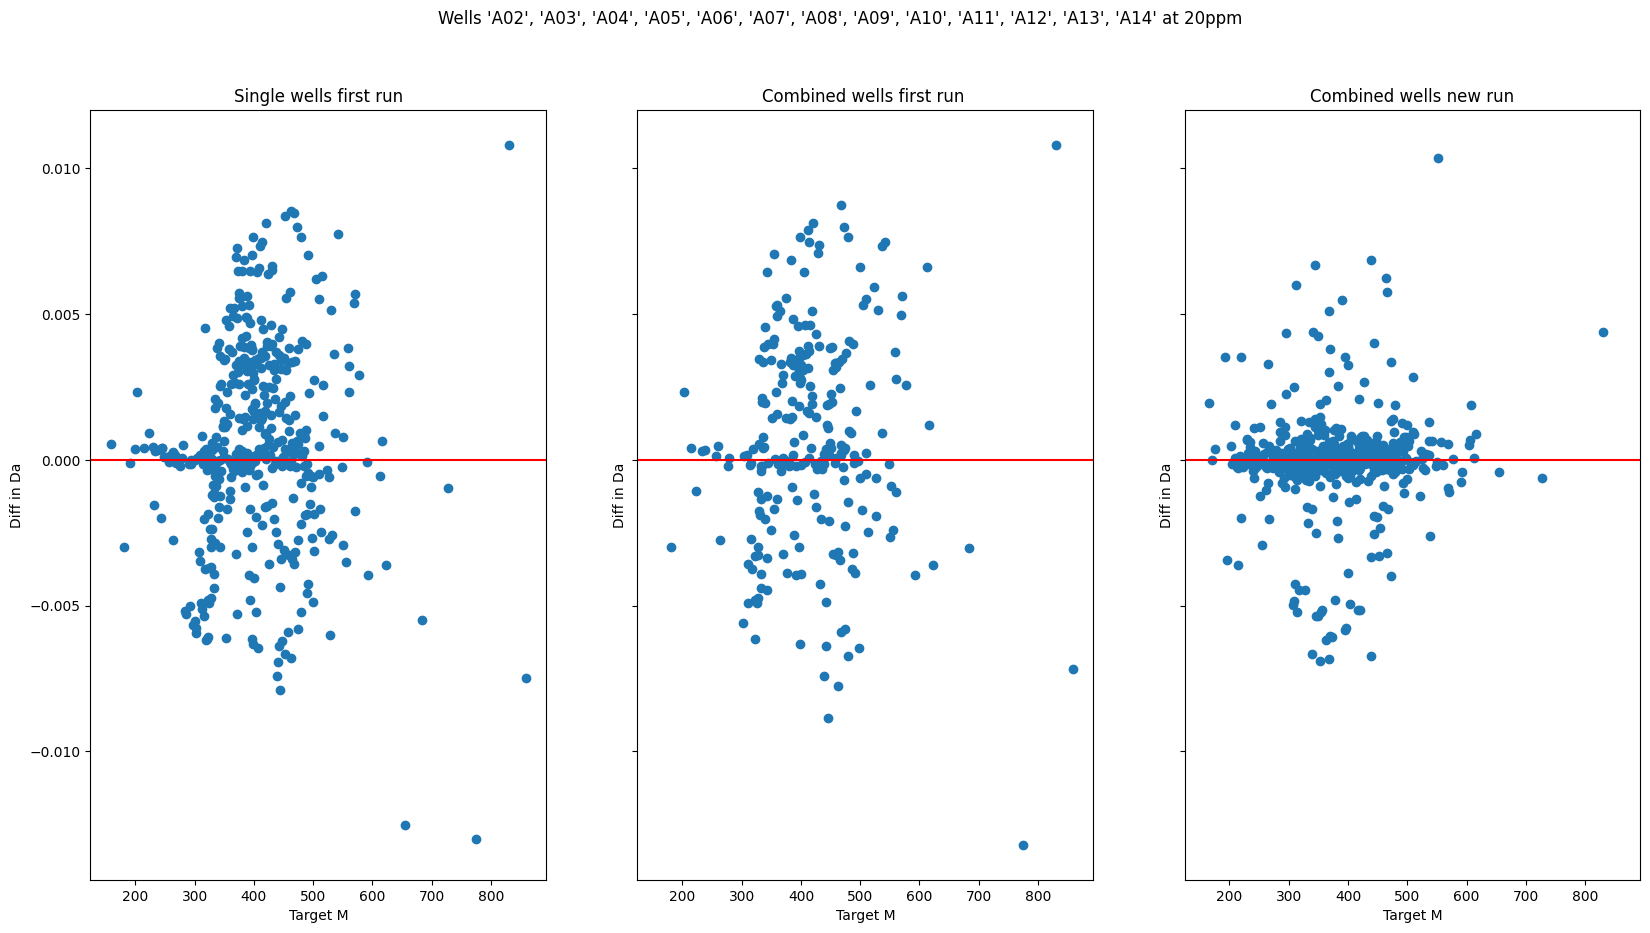

In [15]:
data=data_combined_single.dropna(subset="Target")

fig,ax=plt.subplots(1,3,figsize=(20, 10), sharey=True, sharex=True)
ax[0].scatter(data["Target"],data["PEPMASS"]-data["Target"])
ax[0].set_ylabel("Diff in Da")
ax[0].set_xlabel("Target M")
ax[0].set_title("Single wells first run")
ax[0].axhline(y=0, color='r', linestyle='-')

data=data_combined_old.dropna(subset="Target")
#fig = plt.figure(figsize=(10, 10))

ax[1].scatter(data["Target"],data["PEPMASS"]-data["Target"])
ax[1].set_ylabel("Diff in Da")
ax[1].set_xlabel("Target M")
ax[1].set_title("Combined wells first run ")
ax[1].axhline(y=0, color='r', linestyle='-')
#fig.suptitle("Well A02 to A10")


data=data_combined.dropna(subset="Target")
#fig = plt.figure(figsize=(10, 10))

ax[2].scatter(data["Target"],data["PEPMASS"]-data["Target"])
ax[2].set_ylabel("Diff in Da")
ax[2].set_xlabel("Target M")
ax[2].set_title("Combined wells new run")
ax[2].axhline(y=0, color='r', linestyle='-')
fig.suptitle("Wells "+str(well_list).strip("[").strip("]")+" at "+ str(ppm)+"ppm")

----- Targeting B01
Found 38 / 93 matches at 50 ppm
Internal Standard
Found 0 / 4 matches at 50 ppm
First run
----- Targeting B01
Found 30 / 93 matches at 50 ppm
Internal Standard
Found 0 / 4 matches at 50 ppm


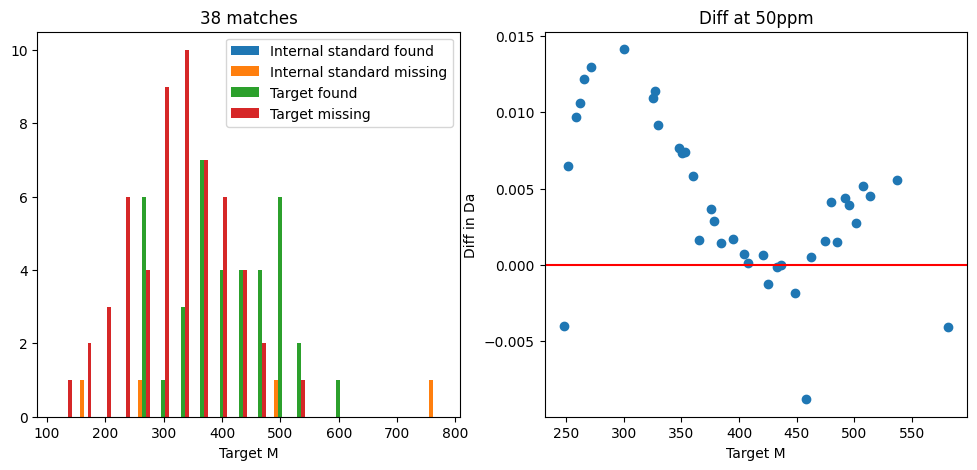

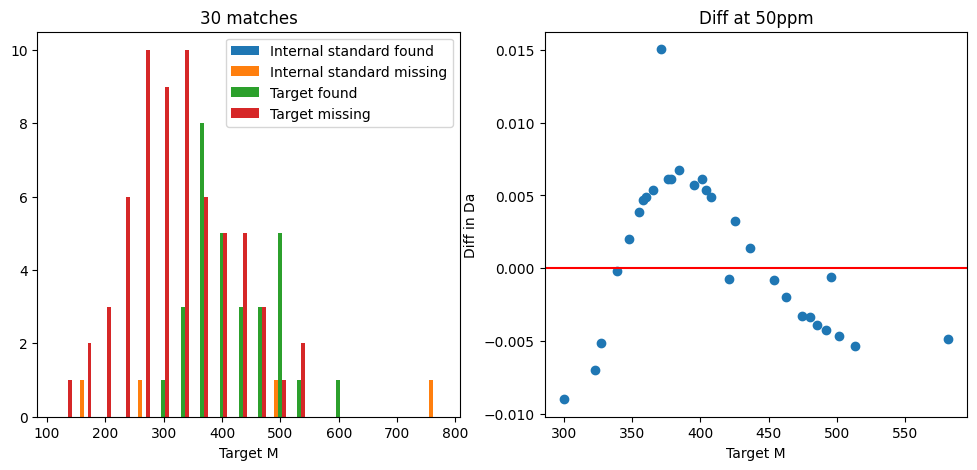

In [33]:

well="B01"
plot_match_and_error(msms,well,50)
print("First run")
plot_match_and_error(msms_old,well,50)

# Test: Merge with MS/MS
- Preprocessing for modelling 


- Full python script exist

In [216]:
data_filtered=data_combined.dropna(subset="Target").iloc[:,[-1,1,2,3,4,8,-4,-3,-2]]

In [217]:
data_filtered.to_csv("matched_A02_B23_new.csv")

In [109]:
def read_rawfile(input_df):
    df_mgf = mgfReader.read(input_df)
    df = pd.DataFrame(df_mgf)
    return df
spectrum=read_rawfile("first_plate/Exported_data/A01_B23_no_recursive_fitting/A01-B23.gnps.mgf")

In [112]:
spectrum["FEATURE_ID"]=spectrum["FEATURE_ID"].astype(int)
    
df=spectrum.merge(data_filtered, right_on="FEATURE_ID", left_on="FEATURE_ID", how="right")
df.columns=['SCANS', 'FEATURE_ID', 'PrecursorMZ', 'MSLEVEL', 'CHARGE', 'POLARITY',
       'RTINMINUTES', 'Precursor_type', 'peaks', "Name", 'RT', 'PrecursorM', 'CCS','ADDUCT',
        'Target', 'SMILES','InChIKey']

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(matched_msms["Target"],matched_msms["PEPMASS"]-matched_msms["Target"])
ax.set_ylabel("Diff")
ax.set_xlabel("Target M")
ax.set_title("Target vs closest in " +target_data+" for tolerance "+str(tolerance))
ax.axhline(y=0, color='r', linestyle='-')
ax.set_ylim(-tolerance,tolerance)

# Process all data

In [31]:
!python match_to_target_combined_df.py -m ../New_run/D01-G24_50/D01-G24.msmsonly.csv -t ../Tims_tof_första_plattan/first_plate_targets.csv -s ../New_run/D01-G24_50/D01-G24.gnps.mgf -p 50 -o test.csv 

Working with Python 3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]
Number of mz found in just one sample:  14725
----- Targeting G09
Found 27 / 93 matches at 50.0 ppm
----- Targeting D05
Found 28 / 98 matches at 50.0 ppm
----- Targeting F20
Found 32 / 93 matches at 50.0 ppm
----- Targeting D24
Found 30 / 93 matches at 50.0 ppm
----- Targeting E09
Found 42 / 96 matches at 50.0 ppm
----- Targeting F17
Found 25 / 93 matches at 50.0 ppm
----- Targeting D23
Found 24 / 95 matches at 50.0 ppm
----- Targeting D20
Found 45 / 98 matches at 50.0 ppm
----- Targeting E19
Found 37 / 95 matches at 50.0 ppm
----- Targeting D06
Found 29 / 97 matches at 50.0 ppm
----- Targeting E07
Found 29 / 96 matches at 50.0 ppm
----- Targeting D17
Found 31 / 95 matches at 50.0 ppm
----- Targeting G15
Found 27 / 89 matches at 50.0 ppm
----- Targeting F24
Found 32 / 97 matches at 50.0 ppm
----- Targeting F13
Found 45 / 93 matches at 50.0 ppm
----- Targeting E01
Found 33 / 89 matches at 

C:\Users\klds816\Box Sync\MS models\Scripts\match_to_target_combined_df.py:83: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  values_df= pd.read_csv(args.target,sep=";")
C:\Users\klds816\Box Sync\MS models\Scripts\match_to_target_combined_df.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_combined=pd.concat([data_combined,data_out])


At 50ppm for A01 to C24
Using Threshold of 1000 (intensity) matches found: 2438
Using Threshold of 50 (intensity) matches found: 2480

At 50ppm for D01 to G24
Using Threshold of 50 (intensity) matches found: 3455

# Train model


Doesn't work on Windows, need fiora

In [226]:
!python filter_data.py -i "A01-B23_matched_new.csv"
! cd ../'MS models'/fiora/notebooks/
!python ../'MS models'/fiora/notebooks/train_model_test.py -i test_A01_B23_processed_new.csv -l 0.00005 -e 100 -t "test_new_mona_tuned" -m ../checkpoint_Mona_only.best.pt

[14:23:33] WARNING: not removing hydrogen atom without neighbors
[14:23:33] WARNING: not removing hydrogen atom without neighbors
[14:23:33] WARNING: not removing hydrogen atom without neighbors
Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
Filtering based on CE and weight
Filtering spectra (1928) down to 1928
Filtering low peak counts
Removed  104 due to less then 2 peaks
Split into training, testing and validation
Running on device: cuda:0
Training model
dataset
test           183
train         1456
validation     183
Name: group_id, dtype: int64
Prepared training/validation with 1641 data points
Using pre-arranged train/validation set
/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the me